### 1. IMPORT KERAS AND LIBRARIES

In [ ]:
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import VGG19
from keras_applications.inception_resnet_v2 import InceptionResNetV2
import pandas as pd
import numpy as np

# Libraries for displying the data. 
from IPython.core.display import HTML 
from ipywidgets import interact
from IPython.display import display
from IPython.display import Image

print(VGG16.__doc__)
print(ResNet50.__doc__)
print(VGG19.__doc__)

In [ ]:
# i am trying to use tensor-gpu just to check if things are fine
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

In [3]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

### 2. HELPER FUNCTIONS

In [4]:
size = 224
def get_input(img_path):
    img = imread(img_path)
    img = resize(img, (size, size,3), preserve_range=True).astype(np.float32)
    #img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [5]:
def get_predictions(img_path, model,decode=True):
    input_ = get_input(img_path)
    out = model.predict(input_)
    if decode:
        return decode_predictions(out)
    else:
        return out

### 3. LOAD DATA FOR DEEP LEARNING

In [6]:
df = pd.read_csv('../data/model/model_data.csv') 
df = df.drop(columns = 'Unnamed: 0')
print(df.shape)
df.head(2)

(17209, 13)


,image_link,product_name,page_link,label,background,delete,item_no,description,style,material,type_class,color,rating
0,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,0,0.0,20370480,"Inspired by 1950's decor, the Brandbu futon is...","Mid-Century Modern, Scandinavian","Foam, Linen, Wood","Futon Set, Sofa","Blue, Green, Grey, Pink, Yellow",4.1
1,https://ak1.ostkcdn.com/images/products/139907...,Carson Carrington Brandbu Mid-century Fold Dow...,https://www.overstock.com/Home-Garden/Carson-C...,sofa,0,0.0,20370480,"Inspired by 1950's decor, the Brandbu futon is...","Mid-Century Modern, Scandinavian","Foam, Linen, Wood","Futon Set, Sofa","Blue, Green, Grey, Pink, Yellow",4.1


### 4. PREPROCESS IMAGES 
Do not run this section

In [ ]:
data_store = []

In [ ]:
counter = 1
for link in df.loc[0:1000,'image_link']:
    print(counter)
    img_data = get_input(link)
    data_store.append(img_data)
    counter+=1
len(data_store)

In [ ]:
len(data_store)
X = np.array(data_store)

In [ ]:
X.shape

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
print(df.shape)
y_str = df['label']
le = LabelEncoder()
y_str = le.fit_transform(y_str)
print(y_str)
y = to_categorical(y_str) # one hot encodes the classes

In [ ]:
y[0]

In [ ]:
# write 
import tables

h5file = tables.open_file('../data/datasets.h5', mode='w', title="Datasets")
root = h5file.root
h5file.create_array(root, "X_full", X)
h5file.create_array(root, "y_full", y)
h5file.close()

### 5. LOAD ALREADY PREPROCESSED IMAGES

In [7]:
# read
import tables

hdf5_file = tables.open_file('../data/datasets.h5', mode='r')
X1 = np.array(hdf5_file.root.X_full)
y1 = np.array(hdf5_file.root.y_full)
hdf5_file.close()

In [8]:
X1.shape

(17209, 224, 224, 3)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, stratify=y1, random_state=36)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12046, 224, 224, 3)
(12046, 5)
(5163, 224, 224, 3)
(5163, 5)


### 6. DEEP LEARNING MODEL

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras import models, layers, optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#### A. MODEL HELPER FUNCTIONS

In [43]:

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
        
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

#### B. SETUP
Lables, base model, optimizer, my layers

In [44]:
# class weight for imbalanced classes not being used
from sklearn.utils import class_weight
#class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [45]:
# map categories for labels
mapcharacter1 = {0:'armchair',1: 'coffee', 2:'pouf', 3: 'sofa', 4: 'tv'}
mapcharacter2 = {0: 'coffee',1: 'sofa', 2: 'tv'}

In [46]:
# set labels, image size, what base-model you want, what optimizer you want

labels = mapcharacter1
imageSize=224
base_network_selector='vgg16' # vgg16,res50
optimizer_selector='adam' 

# select base network
if(base_network_selector=='vgg16'):
    base_model = VGG16(weights='imagenet', include_top=False,\
                          input_shape=(imageSize, imageSize, 3))
if(base_network_selector=='res50'):
    base_model = ResNet50(weights='imagenet',include_top=False,\
                             input_shape=(imageSize, imageSize, 3))
if(base_network_selector=='vgg19'):
    base_model = VGG19(weights='imagenet', include_top=False,\
                          input_shape=(imageSize, imageSize, 3))

# if(base_network_selector=='inv_res'):
#     base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False,\
#                                    input_shape=(imageSize, imageSize, 3))
    
# select the optimizer
if(optimizer_selector=='adam'):    
    my_optimizer = optimizers.Adam()
if(optimizer_selector=='sgd'):     
    my_optimzer = optimizers.SGD()
if(optimizer_selector=='RMS'):
    my_optimzer = optimizers.RMSprop()
if(optimizer_selector=='ada_grad'):
    my_optimzer = optimizers.Adagrad()
if(optimizer_selector=='ada_delta'):
    my_optimzer = optimizers.Adadelta()
if(optimizer_selector=='ada_max'):
    my_optimzer = optimizers.Adamax()

In [47]:
# set ephochs, classes, batch size

numepochs = 20
number_classes = 5
b_size = 32

# Add custom fully connected layers 
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
#x = Dense(32, activation='relu', name='fc3')(x)
x = Dropout(0.50)(x)


# Add the last softmax layer
predictions = Dense(number_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
    
# Freeze layers from the base model
for layer in base_model.layers: 
    layer.trainable = False
    
# Compile model and print its summary
model.compile(loss='categorical_crossentropy', optimizer=my_optimizer, metrics=['accuracy'])
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### C. RUN MODEL

In [48]:
model_file = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
#tensorboard = TensorBoard(log_dir='../logs', histogram_freq=0,
                          #write_graph=True, write_images=False)

In [49]:

augment = False #whether to use augmented data or only only orignal data to train the model

# with augmentation
if (augment == True):
    from keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=True,
        vertical_flip=True)

    datagen.fit(X_train)
    history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=b_size),
                                      steps_per_epoch=len(X_train)/b_size, 
                                      epochs=numepochs,
                                      validation_data=(X_test,y_test), 
                                      verbose=1,
                                      callbacks = [MetricsCheckpoint('logs')])

# no augmentation
if (augment == False):
    history = model.fit(X_train,y_train, batch_size=b_size,epochs=numepochs,validation_data=(X_test,y_test), verbose=1 ,callbacks = [MetricsCheckpoint('logs'),checkpoint,early])

print(history)  

Train on 12046 samples, validate on 5163 samples
Epoch 1/20
12046/12046 [==============================] - 29s 2ms/step - loss: 3.7670 - acc: 0.7468 - val_loss: 1.8766 - val_acc: 0.8772

Epoch 00001: val_acc improved from -inf to 0.87720, saving model to weights.01-1.88.hdf5
Epoch 2/20
12046/12046 [==============================] - 28s 2ms/step - loss: 2.4883 - acc: 0.8369 - val_loss: 1.6060 - val_acc: 0.8972

Epoch 00002: val_acc improved from 0.87720 to 0.89715, saving model to weights.02-1.61.hdf5
Epoch 3/20
12046/12046 [==============================] - 28s 2ms/step - loss: 1.9306 - acc: 0.8749 - val_loss: 1.8547 - val_acc: 0.8805

Epoch 00003: val_acc did not improve from 0.89715
Epoch 4/20
12046/12046 [==============================] - 28s 2ms/step - loss: 1.9201 - acc: 0.8769 - val_loss: 1.5274 - val_acc: 0.9024

Epoch 00004: val_acc improved from 0.89715 to 0.90238, saving model to weights.04-1.53.hdf5
Epoch 5/20
12046/12046 [==============================] - 28s 2ms/step - los

#### D. TEST AND VISUALIZE MODEL 

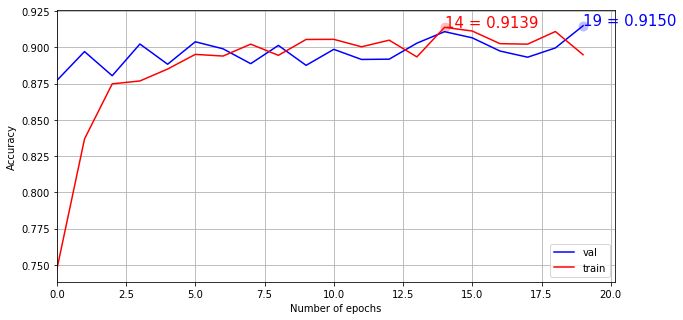

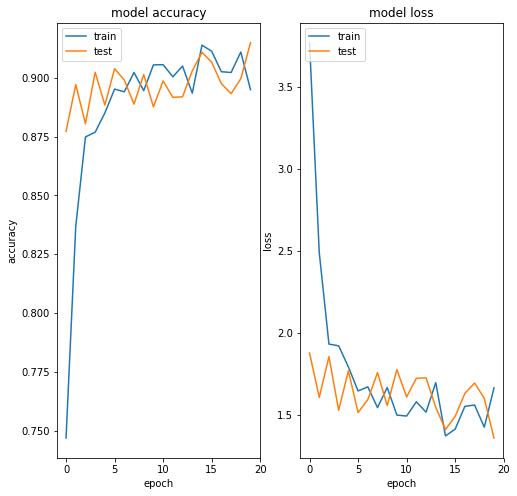

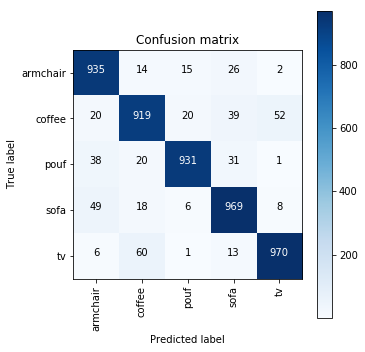

In [50]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)  # reconverts back from one hot encoded 
y_true = np.argmax(y_test,axis = 1)  # reconverts back from one hot encoded
confusion_mtx = confusion_matrix(y_true,y_pred_classes)
plotKerasLearningCurve()
plot_learning_curve(history)
plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))

In [ ]:
z = model.predict(X_test)

In [51]:
model.save('../data/model_final.h5')   